# Stage one

In [1]:
import os
import random
import pprint
from uuid import uuid4
import json

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.data import Dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from project.utils import multi_hot, make_iou, choose_params, f1
from project.preprocess_ingredients import preprocess_ingredients
from project.dataset import load_dataset_for_ingredient_prediction, train_val_test_split
from project.augmentation import make_augmentation, make_resizer

In [2]:
IOU_THRESH = 0.5

#TODO: move up
DATASET_ROOT = os.path.join("project", "dataset")
DATASET_CSV_PATH = os.path.join(DATASET_ROOT, "Food Ingredients and Recipe Dataset with Image Name Mapping.csv")

RUN_DIR = "./runs/custom"
IMG_SIZE = 224
CROP_SIZE = 200 
AUTOTUNE = tf.data.AUTOTUNE
SHUFFLE_SIZE = 1024
EARLY_STOPPING_PATIENCE = 3
MAX_EPOCHS = 25

In [3]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

print(device_lib.list_local_devices())

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13500552282688572923
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6924795904
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3933744804991137330
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


### Data loading

In [5]:
images, ingredients, valid_ingredients_list, dataset_size = load_dataset_for_ingredient_prediction(
    csv_file_path=DATASET_CSV_PATH, 
    preprocess_func=preprocess_ingredients,
    is_ipynb=True
)

NUM_INGREDIENTS = len(valid_ingredients_list)
#multi-hot encode ingredients
ingredients_multihot = ingredients.map(lambda x: multi_hot(x, NUM_INGREDIENTS), num_parallel_calls=tf.data.AUTOTUNE)

Dataset columns: ['id', 'Title', 'Ingredients', 'Instructions', 'Image_Name', 'Cleaned_Ingredients']
Removed 8 rows containing NaN
current path for images: project\dataset\Food Images\Food Images


In [6]:
#train/val/test split
train_x, validation_x, test_x = train_val_test_split(images, dataset_size)
train_y, validation_y, test_y = train_val_test_split(ingredients_multihot, dataset_size)

print(train_x.cardinality().numpy(), "train samples")
print(validation_x.cardinality().numpy(), "validation samples")
print(test_x.cardinality().numpy(), "test samples")

8615 train samples
2154 validation samples
2693 test samples


## Create image preprocessing/augmentation layers

In [7]:
augment = make_augmentation(IMG_SIZE, CROP_SIZE)
resize_only = make_resizer(CROP_SIZE)

(200, 200, 3)
<dtype: 'float32'>


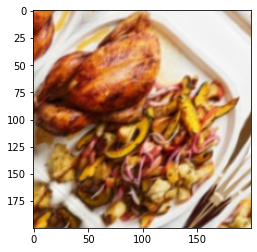

In [8]:
#apply augmentation to training input; specify training=True to ensure it is applied
train_x_augmented = train_x.map(lambda x: augment(x, training=True), num_parallel_calls=tf.data.AUTOTUNE)
train_x_resized = train_x.map(lambda x: resize_only(x, training=True), num_parallel_calls=tf.data.AUTOTUNE)
validation_x_resized = validation_x.map(lambda x: resize_only(x, training=True), num_parallel_calls=tf.data.AUTOTUNE)

#show an augmented image
for img in train_x_augmented:
    print(img.shape)
    #not sure why this is float type here, images are loaded as uint8
    #maybe keras preprocessing layers convert to float
    print(img.dtype)
    plt.figure()
    _ = plt.imshow(img / 255.) #divide by 255 here so image can be shown
    break

## Custom CNN model

In [9]:
def conv_block(depth=32, kernel_size=3, pooling_size=2, batch_norm=True, activation="relu"):
    model = Sequential()
    model.add(Conv2D(depth, kernel_size, activation=activation))
    if batch_norm:
        model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pooling_size))
    return model

#create a custom cnn model with 3-5 conv blocks and one dense hidden layer
def create_model(dense_size=256, conv_blocks=2, activation="relu", l2_reg=1e-3, dropout=0.7, lr=1e-3, metrics=[]):
    model = Sequential()
    model.add(InputLayer((CROP_SIZE, CROP_SIZE, 3)))
    model.add(conv_block(32, 3, 2, True, activation))
    model.add(conv_block(64, 3, 2, True, activation))
    model.add(conv_block(128, 3, 2, True, activation))
    if conv_blocks >= 4:
        model.add(conv_block(256, 3, 2, True, activation))
    if conv_blocks >= 5:
        model.add(conv_block(256, 3, 2, True, activation))
    model.add(Flatten())
    
    kernel_regularizer = l2(l2_reg) if l2_reg is not None else None
    model.add(Dense(dense_size, activation='relu', kernel_regularizer=kernel_regularizer))
    
    if dropout is not None and dropout != 0:
        model.add(Dropout(dropout)) # Added dropout for regularization
        
    #model.add(Dense(y_train_labels.shape[1], activation='sigmoid'))
    model.add(Dense(NUM_INGREDIENTS, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=metrics)
    
    return model

In [10]:
hyperparameter_options = {
    "batch_size": [32, 64, 128],
    "conv_blocks": [3, 4, 5],
    "learning_rate": [1e-3, 1e-4, 1e-5],
    "augmentation": [True, False],
    "regularization": [True, False]
}

choose_params(hyperparameter_options)

{'batch_size': 128,
 'conv_blocks': 5,
 'learning_rate': 0.001,
 'augmentation': False,
 'regularization': False}

In [11]:
def train_custom_cnn_model():
    #create iou metric
    iou = make_iou(IOU_THRESH)
    
    #create id
    uuid = str(uuid4())
    
    #choose hyperparameters randomly
    params = choose_params(hyperparameter_options)
    print("running with hyperparameters:")
    pprint.pprint(params)
    
    #create train and validation datasets by zipping/shuffling
    x = train_x_augmented if params["augmentation"] else train_x_resized
    train_ds = Dataset.zip((x, train_y))
    train_ds = train_ds.shuffle(SHUFFLE_SIZE)

    val_ds = Dataset.zip((validation_x_resized, validation_y))
    
    #create model with hyperparameters
    #also grab the ingredient predictor so we can save it separately from feature extractor
    model = create_model(
        conv_blocks=params["conv_blocks"],
        l2_reg=1e-3 if params["regularization"] else 0,
        dropout=0.7 if params["regularization"] else 0,
        lr=params["learning_rate"],
        metrics=['accuracy', f1, iou]
    )
    
    model.summary()
    
    #early stopping callback
    early_stopping = EarlyStopping(
        patience=EARLY_STOPPING_PATIENCE,
    )
    
    #batch datasets
    train_ds_batched = train_ds.batch(params["batch_size"])
    val_ds_batched = val_ds.batch(params["batch_size"])

    history = model.fit(
        train_ds_batched,
        validation_data=val_ds_batched,
        epochs=MAX_EPOCHS,
        callbacks=[early_stopping],
    )

    #save our ingredient predictor model (not entire resnet), training metrics (history) and hyperparams
    run_path = os.path.join(RUN_DIR, uuid)
    os.makedirs(run_path, exist_ok=True)
    
    model.save(os.path.join(run_path, "ingredient_predictor.keras"))
    
    with open(os.path.join(run_path, "history.json"), "w") as f:
        f.write(json.dumps(history.history, indent=4))
    
    with open(os.path.join(run_path, "params.json"), "w") as f:
        f.write(json.dumps(params, indent=4))

while True:
    train_custom_cnn_model()

running with hyperparameters:
{'augmentation': False,
 'batch_size': 128,
 'conv_blocks': 4,
 'learning_rate': 0.001,
 'regularization': True}
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 99, 99, 32)        1024      
                                                                 
 sequential_3 (Sequential)   (None, 48, 48, 64)        18752     
                                                                 
 sequential_4 (Sequential)   (None, 23, 23, 128)       74368     
                                                                 
 sequential_5 (Sequential)   (None, 10, 10, 256)       296192    
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense (Dense)               (None, 256)   

Epoch 5/25
270/270 [==============================] - 29s 104ms/step - loss: 0.1239 - accuracy: 0.6051 - f1: 0.2168 - iou: 0.1221 - val_loss: 0.1329 - val_accuracy: 0.3143 - val_f1: 0.1129 - val_iou: 0.0602
Epoch 6/25
270/270 [==============================] - 28s 102ms/step - loss: 0.1206 - accuracy: 0.6135 - f1: 0.2229 - iou: 0.1261 - val_loss: 0.1319 - val_accuracy: 0.2957 - val_f1: 0.1051 - val_iou: 0.0558
Epoch 7/25
270/270 [==============================] - 30s 110ms/step - loss: 0.1179 - accuracy: 0.6201 - f1: 0.2300 - iou: 0.1305 - val_loss: 0.1313 - val_accuracy: 0.2799 - val_f1: 0.0947 - val_iou: 0.0501
Epoch 8/25
270/270 [==============================] - 28s 101ms/step - loss: 0.1155 - accuracy: 0.6252 - f1: 0.2365 - iou: 0.1347 - val_loss: 0.1310 - val_accuracy: 0.2878 - val_f1: 0.1000 - val_iou: 0.0530
Epoch 9/25
270/270 [==============================] - 28s 103ms/step - loss: 0.1130 - accuracy: 0.6200 - f1: 0.2446 - iou: 0.1399 - val_loss: 0.1310 - val_accuracy: 0.2832 

running with hyperparameters:
{'augmentation': True,
 'batch_size': 64,
 'conv_blocks': 3,
 'learning_rate': 0.0001,
 'regularization': True}
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_18 (Sequential)  (None, 99, 99, 32)        1024      
                                                                 
 sequential_19 (Sequential)  (None, 48, 48, 64)        18752     
                                                                 
 sequential_20 (Sequential)  (None, 23, 23, 128)       74368     
                                                                 
 flatten_3 (Flatten)         (None, 67712)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               17334528  
                                                                 
 dropout_2 (Dropout)         (None, 256)   

Trainable params: 6,996,688
Non-trainable params: 960
_________________________________________________________________
Epoch 1/25
68/68 [==============================] - 86s 1s/step - loss: 1.1459 - accuracy: 0.0742 - f1: 0.0730 - iou: 0.0379 - val_loss: 1.1132 - val_accuracy: 0.0757 - val_f1: 0.0664 - val_iou: 0.0343
Epoch 2/25
68/68 [==============================] - 71s 942ms/step - loss: 0.8860 - accuracy: 0.0375 - f1: 0.0806 - iou: 0.0420 - val_loss: 0.7923 - val_accuracy: 0.0562 - val_f1: 0.0787 - val_iou: 0.0410
Epoch 3/25
68/68 [==============================] - 67s 913ms/step - loss: 0.6259 - accuracy: 0.0917 - f1: 0.0991 - iou: 0.0522 - val_loss: 0.4540 - val_accuracy: 0.3366 - val_f1: 0.1032 - val_iou: 0.0545
Epoch 4/25
68/68 [==============================] - 61s 810ms/step - loss: 0.4838 - accuracy: 0.1914 - f1: 0.1282 - iou: 0.0685 - val_loss: 0.3608 - val_accuracy: 0.3816 - val_f1: 0.0963 - val_iou: 0.0507
Epoch 5/25
68/68 [==============================] - 56s 757ms/s

KeyboardInterrupt: 

## Predict

In [ ]:
image_test='/content/drive/MyDrive/meat.jpg/'

In [ ]:
import numpy as np

# Load and preprocess the image want to predict
new_image_path = image_test

new_image = load_and_preprocess_image(new_image_path, image_height, image_width)

#  create a batch of size 1 for prediction
input_data = np.array([new_image])

# Make predictions
predictions = model.predict(input_data)

# 'predictions' will contain the model's output for the new image


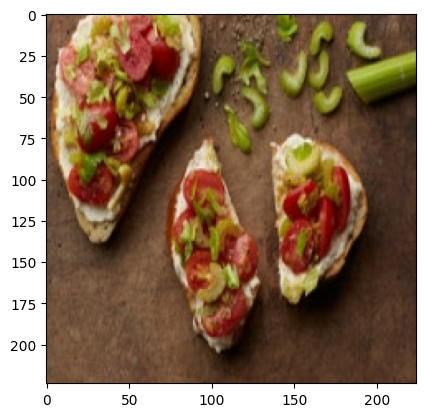

In [ ]:
plt.imshow(new_image, cmap='viridis')
plt.show()

In [ ]:
predictions

array([[1.65100298e-26, 4.62475414e-12, 9.06386452e-16, 1.77750289e-02,
        2.92817311e-23, 1.16205507e-08, 2.53363737e-07, 2.34772253e-25,
        1.06336960e-16, 7.37765539e-21, 1.35901345e-07, 7.24627196e-24,
        1.08273796e-18, 2.65470234e-17, 6.34219637e-03, 4.65003949e-17,
        7.41369906e-04, 8.82571207e-23, 8.14310505e-23, 6.89248811e-21,
        1.59322948e-15, 1.28754107e-09, 6.88345585e-19, 6.01648991e-19,
        9.79033357e-05, 1.12696250e-11, 4.26614370e-15, 5.40635418e-25,
        4.22366497e-07, 6.02677945e-27, 7.42943021e-19, 8.61690038e-21,
        2.03075276e-26, 7.71310249e-20, 1.06646950e-23, 4.74363312e-25,
        1.15661550e-19, 1.80204931e-11, 6.02473505e-02, 5.98221505e-24,
        8.37891067e-21, 9.66053058e-20, 1.74013817e-19, 9.14352049e-18,
        2.67805656e-24, 2.88154074e-18, 1.52753363e-19, 3.09025884e-28,
        1.28267004e-14, 8.58162100e-17, 2.64849384e-23, 2.98117442e-08,
        1.35749578e-02, 9.57143611e-19, 1.86035025e-13, 6.618679

In [ ]:
labels.columns

Index(['ackee', 'acorn squash', 'agar-agar', 'ale', 'alfalfa sprouts',
       'allspice', 'almond', 'almond extract', 'amaranth', 'amaretti',
       ...
       'wild mushrooms', 'wild rice', 'wine', 'worcestershire sauce', 'wraps',
       'yam', 'yeast', 'yellow lentil', 'yoghurt', 'zest'],
      dtype='object', length=817)

In [ ]:
# Define the threshold value
threshold = 0.2  # Adjust this value based on the desired confidence level

# Create an empty list to store the true ingredients
true_ingredients = []

# Iterate through the list of ingredients
for i in range(len(predictions[0])):
    # Check if the probability for this ingredient is above the threshold
    # print(predictions[0][i])
    if predictions[0][i] >= threshold:
        # print(predictions[0][i])
        true_ingredients.append(labels.columns[i])

# The true_ingredients list will now contain the ingredients that meet the threshold
print("True Ingredients:", true_ingredients)


True Ingredients: ['garlic', 'gin', 'oil', 'olive', 'olive oil', 'pepper', 'salt']


Model Summary:

My model is designed for multi-label image classification, where I predict a set of ingredients for a given food image. The model architecture is relatively simple, consisting of a few convolutional and dense layers:

Input Layer: The input layer expects images with dimensions (224, 224, 3), representing 224x224 pixel images with three color channels (RGB).

Convolutional Layers: Two convolutional layers with max-pooling are used for feature extraction. The first layer has 32 filters, and the second layer has 64 filters. These layers are responsible for learning image features.

Flatten Layer: I flatten the feature maps to feed them into the dense layers.

Dense Layers: I have two dense layers, one with 128 neurons and another with a number of neurons equal to the number of ingredients I am predicting (350 in my case). I use the sigmoid activation function in the final dense layer for multi-label classification.

Compilation: My model is compiled with the Adam optimizer and binary cross-entropy loss, suitable for multi-label classification tasks.

Possible Reasons for Lower Accuracy:

Model Complexity: My model is relatively simple. For a task involving thousands of ingredients, a more complex architecture might be necessary. Deeper networks, transfer learning from pre-trained models, and attention mechanisms can help capture intricate details in images.

Training Data: The quality and quantity of my training data can significantly impact accuracy. If the dataset is small or contains noisy or imbalanced labels, my model may struggle to generalize effectively. I should ensure that my data is clean and well-labeled.

Imbalanced Data: If some ingredients are significantly more common in the dataset than others, my model may be biased towards those ingredients. Techniques like class weighting can help address this issue.

Hyperparameter Tuning: I should experiment with different hyperparameters, such as learning rate, batch size, and the number of layers/neurons in the model. Fine-tuning these can have a substantial impact on accuracy.

Overfitting: I should check for signs of overfitting by monitoring the training and validation loss curves. I may need to apply regularization techniques like dropout or L2 regularization to prevent overfitting.

Data Augmentation: Data augmentation techniques can be used to artificially increase the size of my training dataset, which can help my model generalize better.

Label Encoding: I must ensure that my labels are correctly encoded using multi-label binarization to handle multi-label classification.

Training Duration: Training for more epochs may be required to achieve better accuracy. However, I should be cautious of overfitting.

Evaluation Metrics: I should consider using appropriate evaluation metrics for multi-label classification, such as F1-score, Hamming loss, or Jaccard score, in addition to accuracy.

Complexity of the Task: Predicting from a large set of ingredients is a challenging task. It might be worthwhile to first focus on predicting a subset of ingredients that occur more frequently and then expand to the entire set as my model's performance improves.

By addressing these factors, I can work to improve the accuracy of my model for the task at hand.